In [123]:
import pandas as pd
import matplotlib.pyplot as plt

In [124]:
import numpy as np

In [125]:
df = pd.read_excel('data/pone.0148733.s001.xlsx', sheet_name='data', index_col = 'ID')

In [126]:
df.head()

,Sex,Diagnosis,Location,KI,GTV,Stereotactic methods,status,OS
ID,,,,,,,,
1,0,0.0,0,90,6.11,0,0,57.639344
2,1,2.0,1,90,19.35,1,1,8.983607
3,0,0.0,0,70,7.95,0,0,26.459016
4,0,1.0,1,80,7.61,1,1,47.803279
6,1,2.0,1,90,5.06,1,1,6.295082


In [127]:
if 'OS' in df.columns:
    df.rename(columns = {'OS':'time'}, inplace = True)

### Estimating $S(20) = P(T > 20)$

#### Appraoch 1 - compute the proportion of patients who are known to survive alteast 20 months.

In [128]:
# probability that the patient survives at least 20 months.
print(f"No. of patients with survival time > 20 = {df[df['time']> 20].shape[0]}")

No. of patients with survival time > 20 = 48


In [129]:
print(f"Proportion of patients with survival time > 20 = {df[df['time'] > 20].shape[0]/df.shape[0]}")

Proportion of patients with survival time > 20 = 0.5454545454545454


This appraoch is not right since the 17 out of 40 patients who did not survive to 20 months were actually censored. And this method implicitely assumes that T < 20 for these patients.

In [130]:
# df[df['time'] <= 20].status.value_counts()
print(f"No. of patients with time <= 20 = {df[df['time'] <= 20].shape[0]}")

No. of patients with time <= 20 = 40


In [131]:
print(f"Number of those patients alive  = {df[(df['time'] <= 20) &(df['status'] == 0)].shape[0]}")

Number of those patients alive  = 17


So 17 out of 40 patients were alive with there last observation time being less than 20 months. So we can't assume that these people died before 20 months.

#### Approach 2 - Calculating the proportion of non censored obs after time T vs overall w.r.t Time T

In [132]:
# patients for whome last reported time is > 20
print(f"Patients for whome last reported time is > 20 = {df[df['time'] > 20].shape[0]}")

Patients for whome last reported time is > 20 = 48


In [133]:
# patients who are not censored fefore 20 months
# (patients who died before 20 months + patients who survived/died after 20 months) 
died_before_t = df[(df['time'] <= 20) & (df['status'] == 1)].shape[0]
have_data_after_t = df[df['time'] > 20].shape[0]
print(f'Patient who are not censored till 20 months = {died_before_t+have_data_after_t}')

Patient who are not censored till 20 months = 71


In [134]:
# patients for whome the last observation time > 20
print(f'Patients for whome the last observation time is > 20 = {have_data_after_t}')

Patients for whome the last observation time is > 20 = 48


In [135]:
print(f'The estimated proba of P(T > 20) = {have_data_after_t/(died_before_t + have_data_after_t)}')

The estimated proba of P(T > 20) = 0.676056338028169


This estimate is also not correct since it completely ignores the patients who are censored before the time 20

#### Approach 3  -The Kaplan Meier Curve

Let $d_1, d_2, d_3, ..., d_k$ denote the $K$ unique death time among the non-censored patients.

$q_k$ number of patients who have died at the time $d_k$.

$r_k$ number of patients alive and in the study just before $d_k$ - *at risk patients*

By the law of probability - 
$$P(T > d_k) = P(T > d_k|T > d_{k-1})P(T > d_{k-1}) + P(T > d_k|T \leq d_{k-1})P(T \leq d_{k-1})$$
$$S(d_k) = P(T > d_k|T > d_{k-1})P(T > d_{k-1})$$
$$S(d_k) = P(T > d_k|T > d_{k-1})S(d_{k-1})$$
$$S(dk) = Pr(T>d_k|T>d_{k−1}) ×···×Pr(T>d_2|T>d_1) Pr(T>d_1)$$

$$\hat{P}((T > d_j|T > d_{j-1})) = \frac{r_{j} - q_{j}}{r_{j}}$$

The estimated probability value is  = $\frac{\text{number of people alive just before time }{d_j} - \text{number of people dies at time }{d_j}}{\text{number of people alive just after }{d_{j-1}}}$

Kaplan Meier Survival Curve is given by - 
$$\hat{S}(d_k) = \Pi_{j = 1}^{k}\frac{r_j - q_j}{r_j}$$

For times $t \in (d_k, d_{k+1})$,  $\hat{S}(t) = \hat{S}(d_k)$, hence it is a step function


In [136]:
df2 = df.copy()
df.sort_values(by = 'time', inplace = True)

In [137]:
df

,Sex,Diagnosis,Location,KI,GTV,Stereotactic methods,status,time
ID,,,,,,,,
33,1,2.0,1,70,33.69,1,1,0.065574
94,1,1.0,0,90,30.41,1,0,1.180328
56,1,0.0,1,70,0.97,1,1,1.409836
91,0,0.0,0,70,2.94,0,0,1.540984
47,0,0.0,1,80,1.57,1,0,2.032787
...,...,...,...,...,...,...,...,...
35,0,0.0,1,90,4.72,0,0,65.016393
73,1,0.0,1,80,4.77,1,0,67.377049
86,0,0.0,1,80,2.39,0,0,73.737705


In [138]:
TOTAL_PATIENTS = len(df)
df['r_k'] = None
df['r_k'] = 1
df['r_k'] = df['r_k'].cumsum()
df['r_k'] = TOTAL_PATIENTS - df['r_k']
df

,Sex,Diagnosis,Location,KI,GTV,Stereotactic methods,status,time,r_k
ID,,,,,,,,,
33,1,2.0,1,70,33.69,1,1,0.065574,87
94,1,1.0,0,90,30.41,1,0,1.180328,86
56,1,0.0,1,70,0.97,1,1,1.409836,85
91,0,0.0,0,70,2.94,0,0,1.540984,84
47,0,0.0,1,80,1.57,1,0,2.032787,83
...,...,...,...,...,...,...,...,...,...
35,0,0.0,1,90,4.72,0,0,65.016393,4
73,1,0.0,1,80,4.77,1,0,67.377049,3
86,0,0.0,1,80,2.39,0,0,73.737705,2


In [139]:
df.loc[df['status'] == 1, 'q_k'] = 1
df.loc[df['status'] == 1, 'q_k'] = df[df['status'] == 1].groupby('time')['q_k'].cumsum()

In [140]:
# df.loc[df['status'] == 1, 's_dk'] = 1
df.loc[df['status'] == 1, 's_dk'] = (df['r_k'] - df['q_k'])/df['r_k']
df.loc[df['status'] == 1, 's_dk'] = df.loc[df['status'] == 1]['s_dk'].cumprod()

In [141]:
df['q_k'].fillna(0, inplace = True)
df['s_dk'].fillna(method='ffill', inplace=True)

In [142]:
df

,Sex,Diagnosis,Location,KI,GTV,Stereotactic methods,status,time,r_k,q_k,s_dk
ID,,,,,,,,,,,
33,1,2.0,1,70,33.69,1,1,0.065574,87,1.0,0.988506
94,1,1.0,0,90,30.41,1,0,1.180328,86,0.0,0.988506
56,1,0.0,1,70,0.97,1,1,1.409836,85,1.0,0.976876
91,0,0.0,0,70,2.94,0,0,1.540984,84,0.0,0.976876
47,0,0.0,1,80,1.57,1,0,2.032787,83,0.0,0.976876
...,...,...,...,...,...,...,...,...,...,...,...
35,0,0.0,1,90,4.72,0,0,65.016393,4,0.0,0.438282
73,1,0.0,1,80,4.77,1,0,67.377049,3,0.0,0.438282
86,0,0.0,1,80,2.39,0,0,73.737705,2,0.0,0.438282


In [143]:
import matplotlib.pyplot as plt

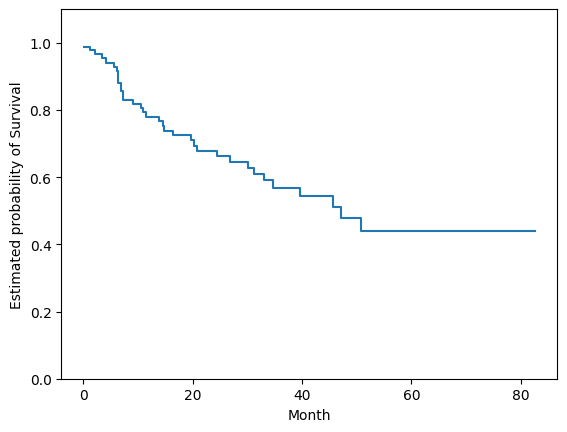

In [146]:
plt.step(df['time'], df['s_dk'])
plt.xlabel('Month')
plt.ylabel('Estimated probability of Survival')
plt.ylim(0, 1.1)
plt.show()

In [147]:
df['s_dk'].min()

0.4382815115517136

In [148]:
df[df['time'] > 20]['s_dk'].iloc[0]

0.7095045146589173

The probability of survival after 20 months $S(T>20) \approx 0.71$

### Approach 3 - Kaplan Meier Curve 
https://towardsdatascience.com/kaplan-meier-curve-explained-9c78a681faca

In [94]:
df3 = df2[['time', 'status']]
df3.sort_values(by = 'time', inplace = True)

/tmp/ipykernel_3429372/1319138255.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by = 'time', inplace = True)


In [111]:
# Prepare unique durations in ascending order
times = df3.sort_values('time')['time'].unique()
# Initialise the table
columns = ['time', 'n_at_risk', 'n_events', 
           'survival_probability']
km = pd.DataFrame(columns=columns, dtype=np.number)
km = km.append(pd.DataFrame([[0, df3.shape[0], 0, 1]], 
                            columns=columns))

/tmp/ipykernel_3429372/2908002022.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  km = km.append(pd.DataFrame([[0, df3.shape[0], 0, 1]],


In [112]:
km

,time,n_at_risk,n_events,survival_probability
0,0.0,88.0,0.0,1.0


In [113]:
# Calculate survival probability for each duration
for i, t in enumerate(times):
    n = df3.shape[0] - np.sum(df3['time'] < t) 
    d = np.sum((df3['time']==t) & (df3['status']==1))
    s = (1 - d / n) * km.loc[i, 'survival_probability']
    km = km.append(pd.DataFrame([[t, n, d, s]], 
                                index=[i+1],
                                columns=columns))
km

/tmp/ipykernel_3429372/3417795425.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  km = km.append(pd.DataFrame([[t, n, d, s]],
/tmp/ipykernel_3429372/3417795425.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  km = km.append(pd.DataFrame([[t, n, d, s]],
/tmp/ipykernel_3429372/3417795425.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  km = km.append(pd.DataFrame([[t, n, d, s]],
/tmp/ipykernel_3429372/3417795425.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  km = km.append(pd.DataFrame([[t, n, d, s]],
/tmp/ipykernel_3429372/3417795425.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas

,time,n_at_risk,n_events,survival_probability
0,0.000000,88.0,0.0,1.000000
1,0.065574,88.0,1.0,0.988636
2,1.180328,87.0,0.0,0.988636
3,1.409836,86.0,1.0,0.977141
4,1.540984,85.0,0.0,0.977141
...,...,...,...,...
82,65.016393,5.0,0.0,0.451543
83,67.377049,4.0,0.0,0.451543
84,73.737705,3.0,0.0,0.451543
85,78.754098,2.0,0.0,0.451543


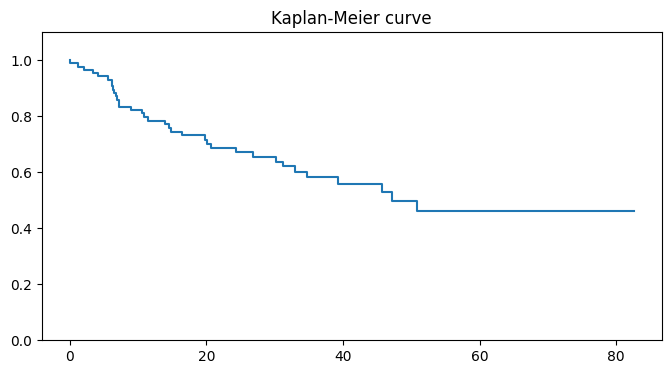

In [110]:
plt.figure(figsize=(8,4))
plt.step(km['time'], km['survival_probability'])
plt.ylim(0,1.1) 
plt.title("Kaplan-Meier curve");